In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time

### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt
import matplotlib.cm                     as cm
import matplotlib.animation              as animation

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
OutputDir   = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/Rect_500Instants_TransRotScale_Diff/')
FigDir      = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')

RandFlg     = True

Nt          = 500
Nx          = 100
Ny          = 100

RotFlg      = True
TransFlg    = True
ScaleFlg    = True

PlotFlg     = False
SaveFlg     = True
n_modes_vec = None#[32,64,128]


ColorVec    = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

OutputDir += '/Orig/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

TempDir = OutputDir+'/train/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = OutputDir+'/test/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

Text(0, 0.5, '$\\theta$ [deg]')

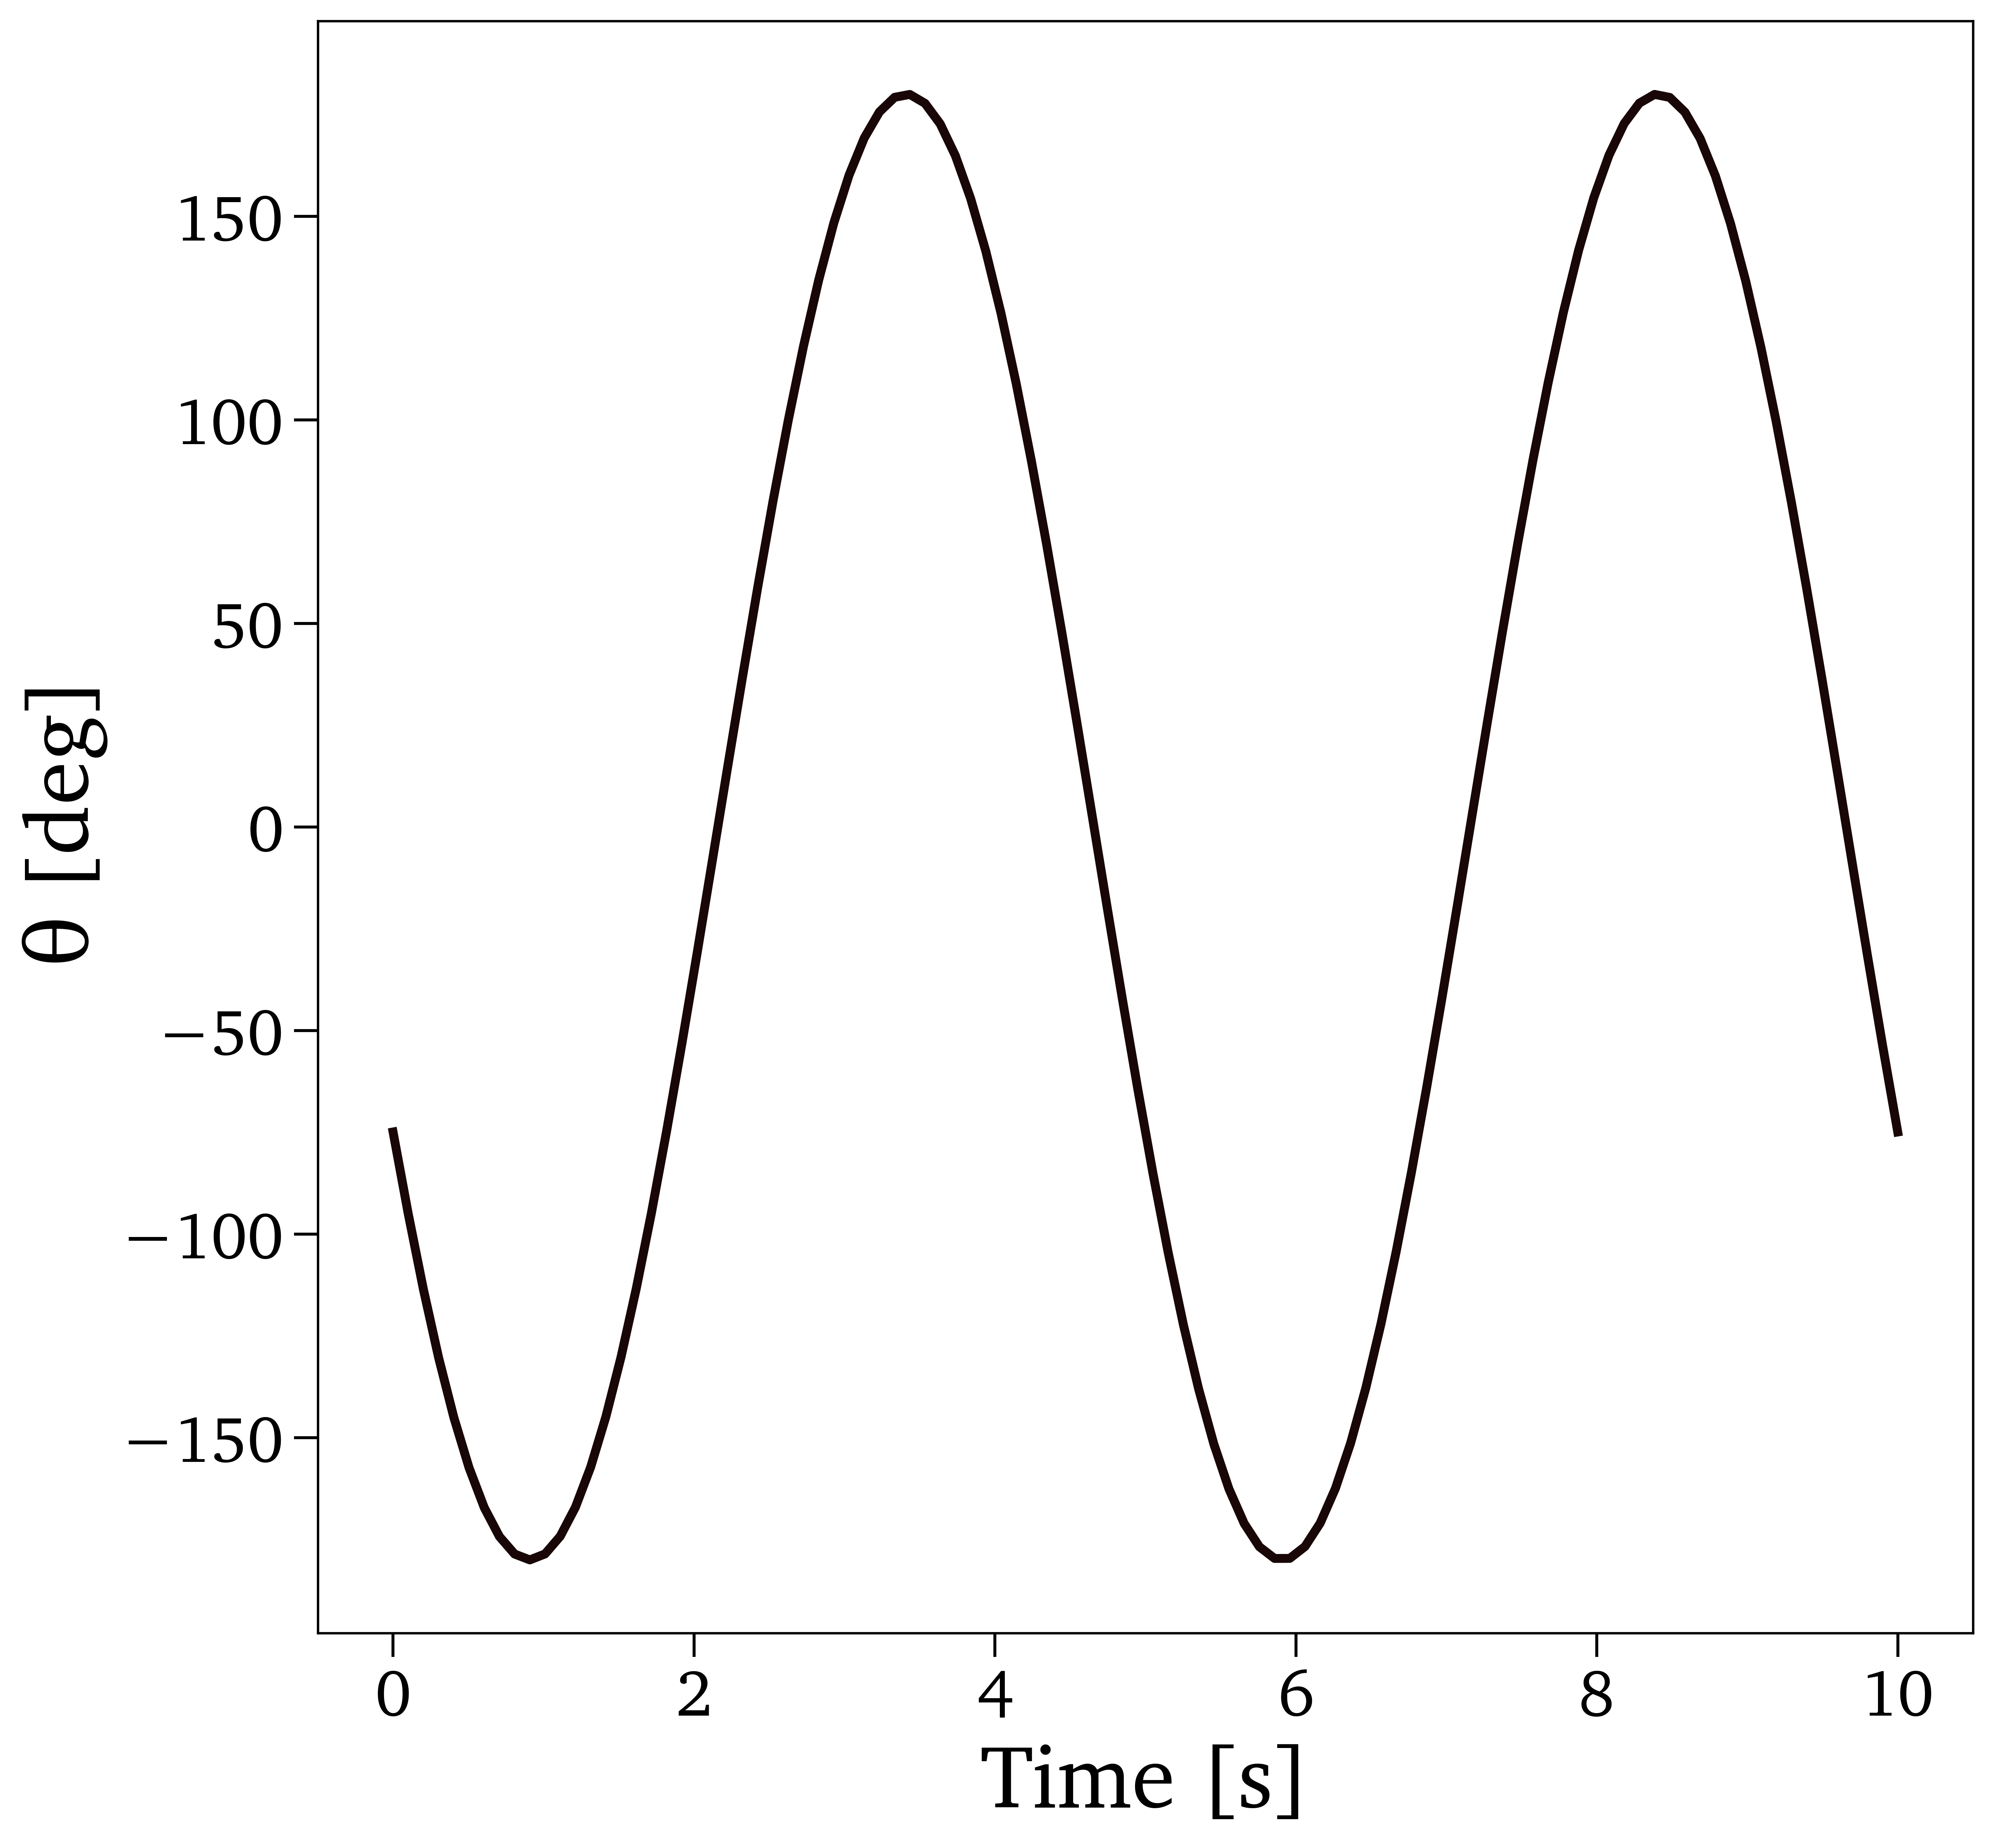

In [3]:
Theta0  = 0./180*np.pi
w_Theta = 36./180*np.pi

tVec    = np.linspace(0.,10.,100)

#Theta   = Theta0 + w_Theta*tVec
Theta   = Theta0 + np.cos(tVec/10.*(4*np.pi)+2.)*np.pi
    
plt.plot(tVec,Theta*180/np.pi,'-')

plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [deg]')

Text(0, 0.5, '$y_c$')

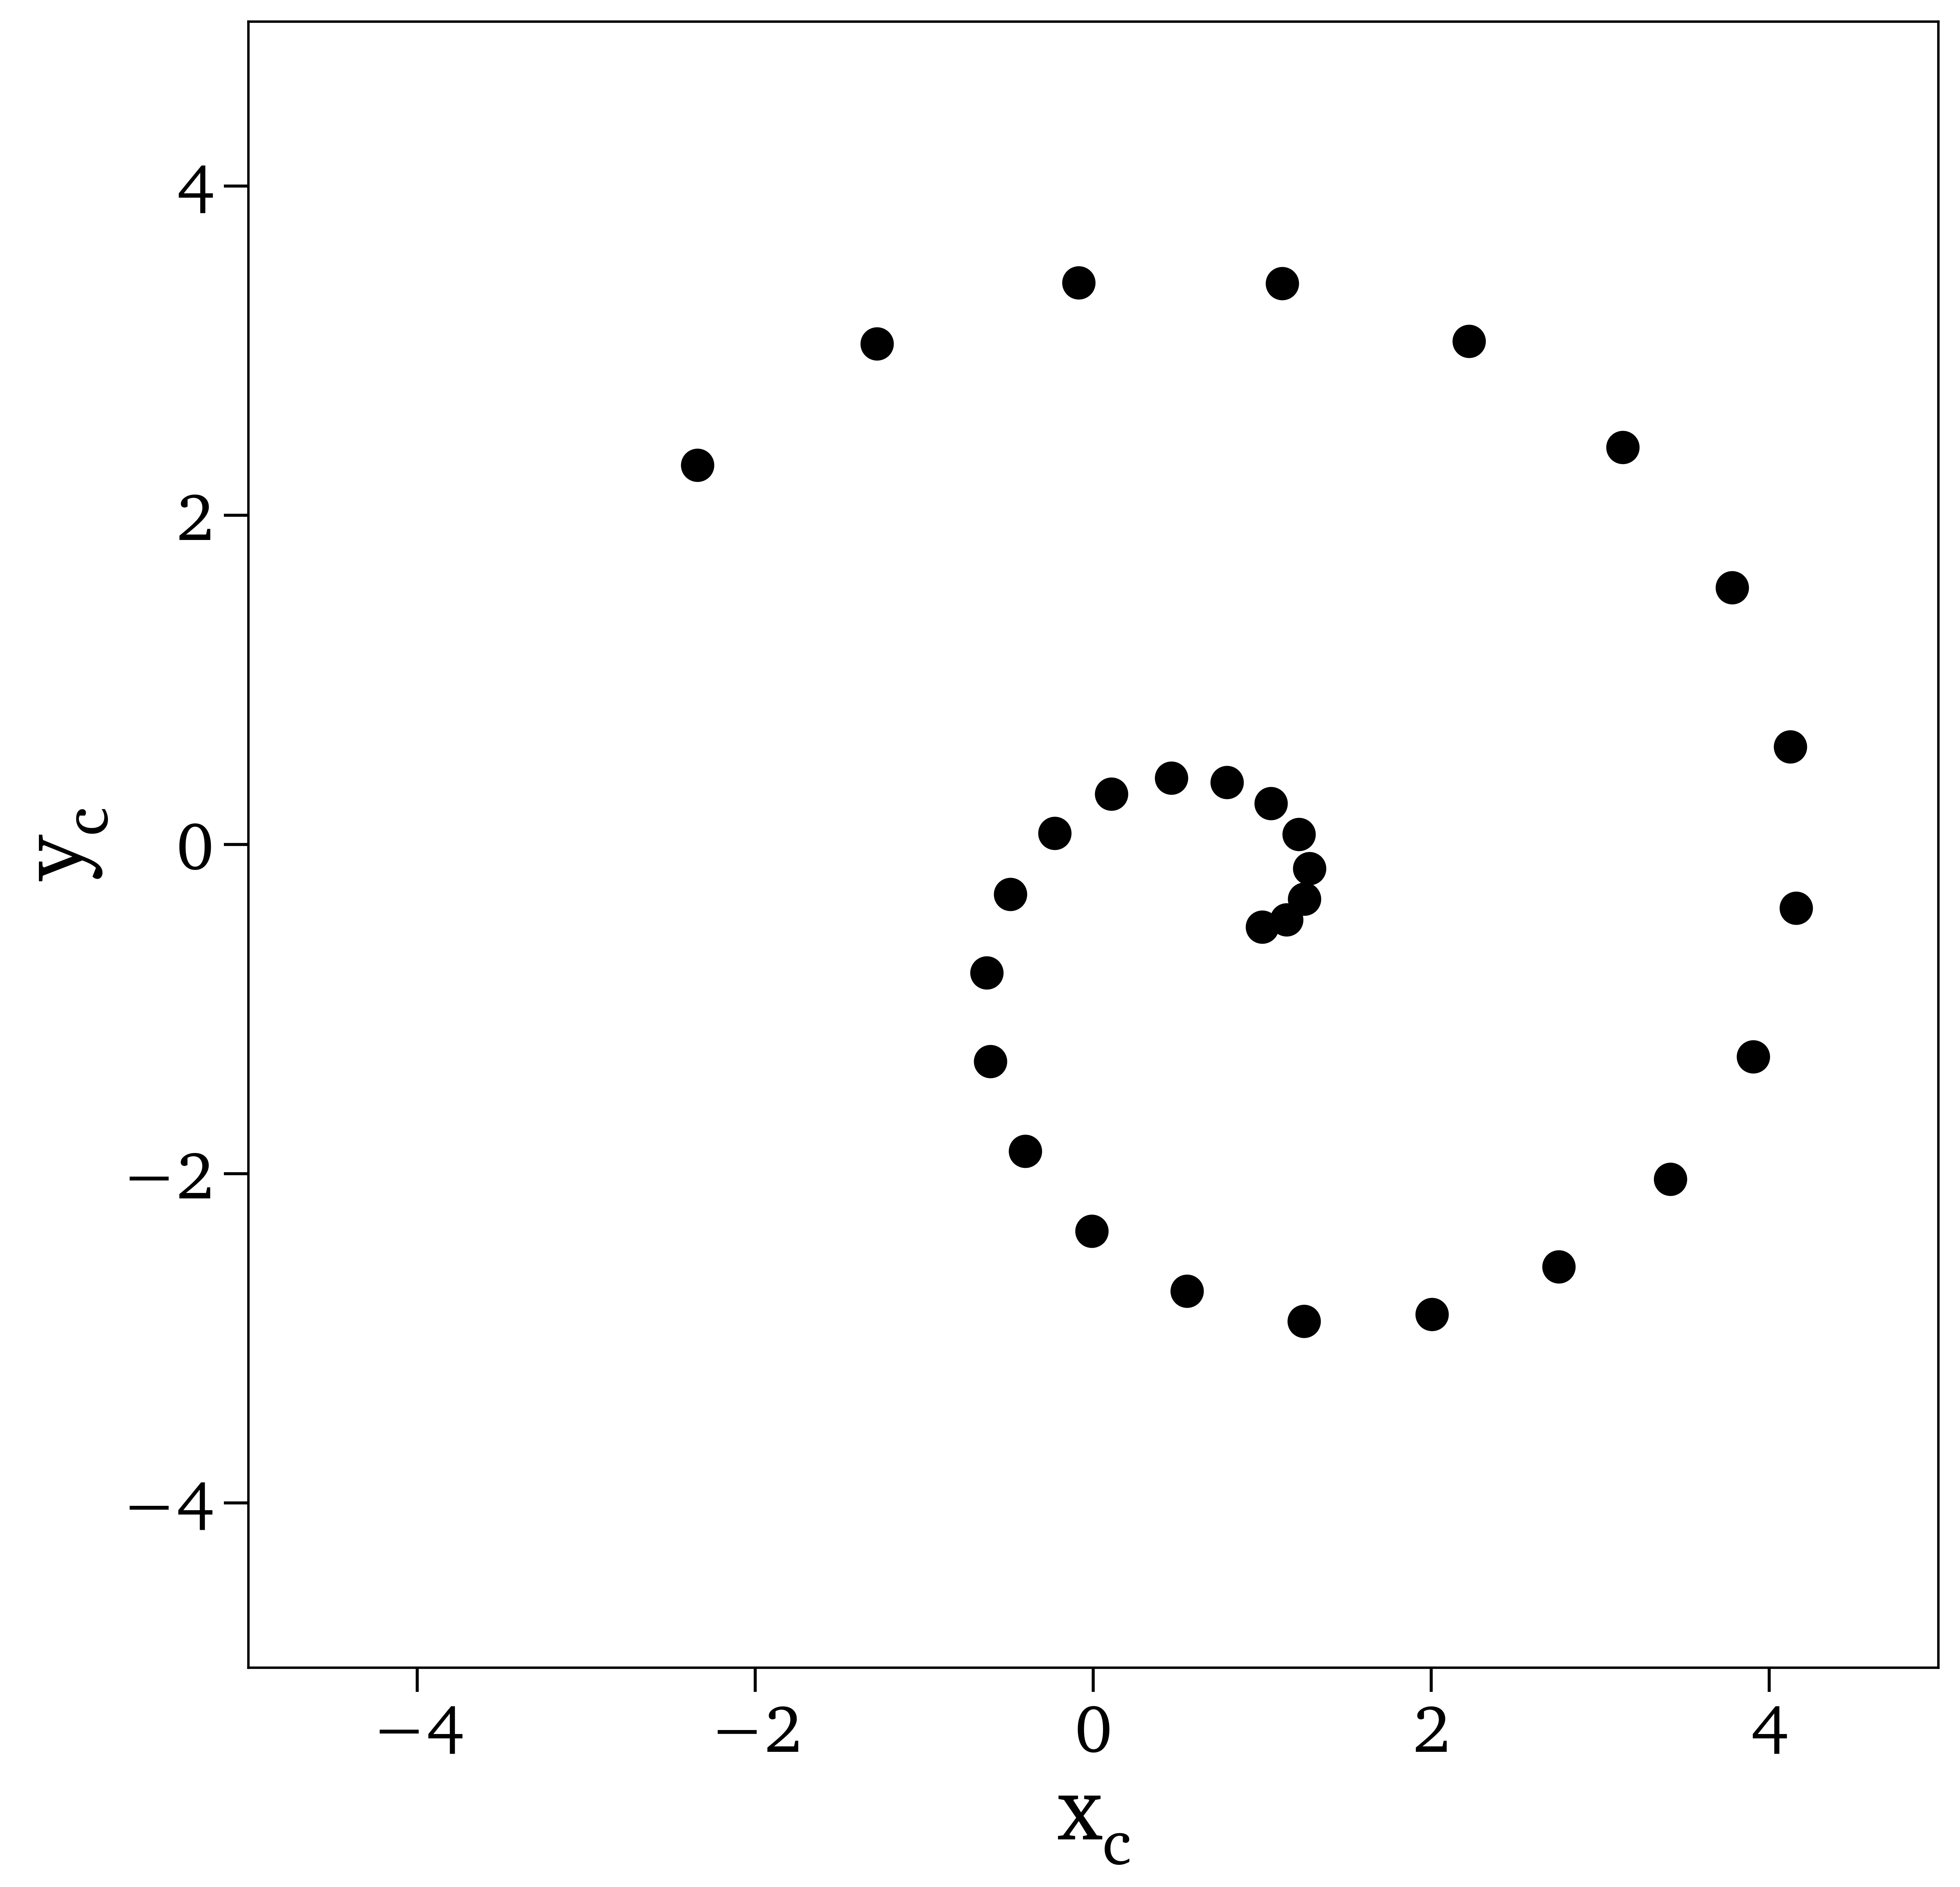

In [4]:
w_Psi = 50./180*np.pi
ca    = 0.5
cx0   = 1.
cy0   = -0.5

tVec    = np.linspace(0.,10.,30)
for it, t in enumerate(tVec):
    Psi   = t*w_Psi
    cr    = ca * Psi
    cx    = cx0 + cr * np.cos(Psi)
    cy    = cy0 + cr * np.sin(Psi)    
    
    plt.plot(cx,cy,'ko')
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    
plt.xlabel(r'$x_c$')
plt.ylabel(r'$y_c$')

Text(0, 0.5, 'Scalings')

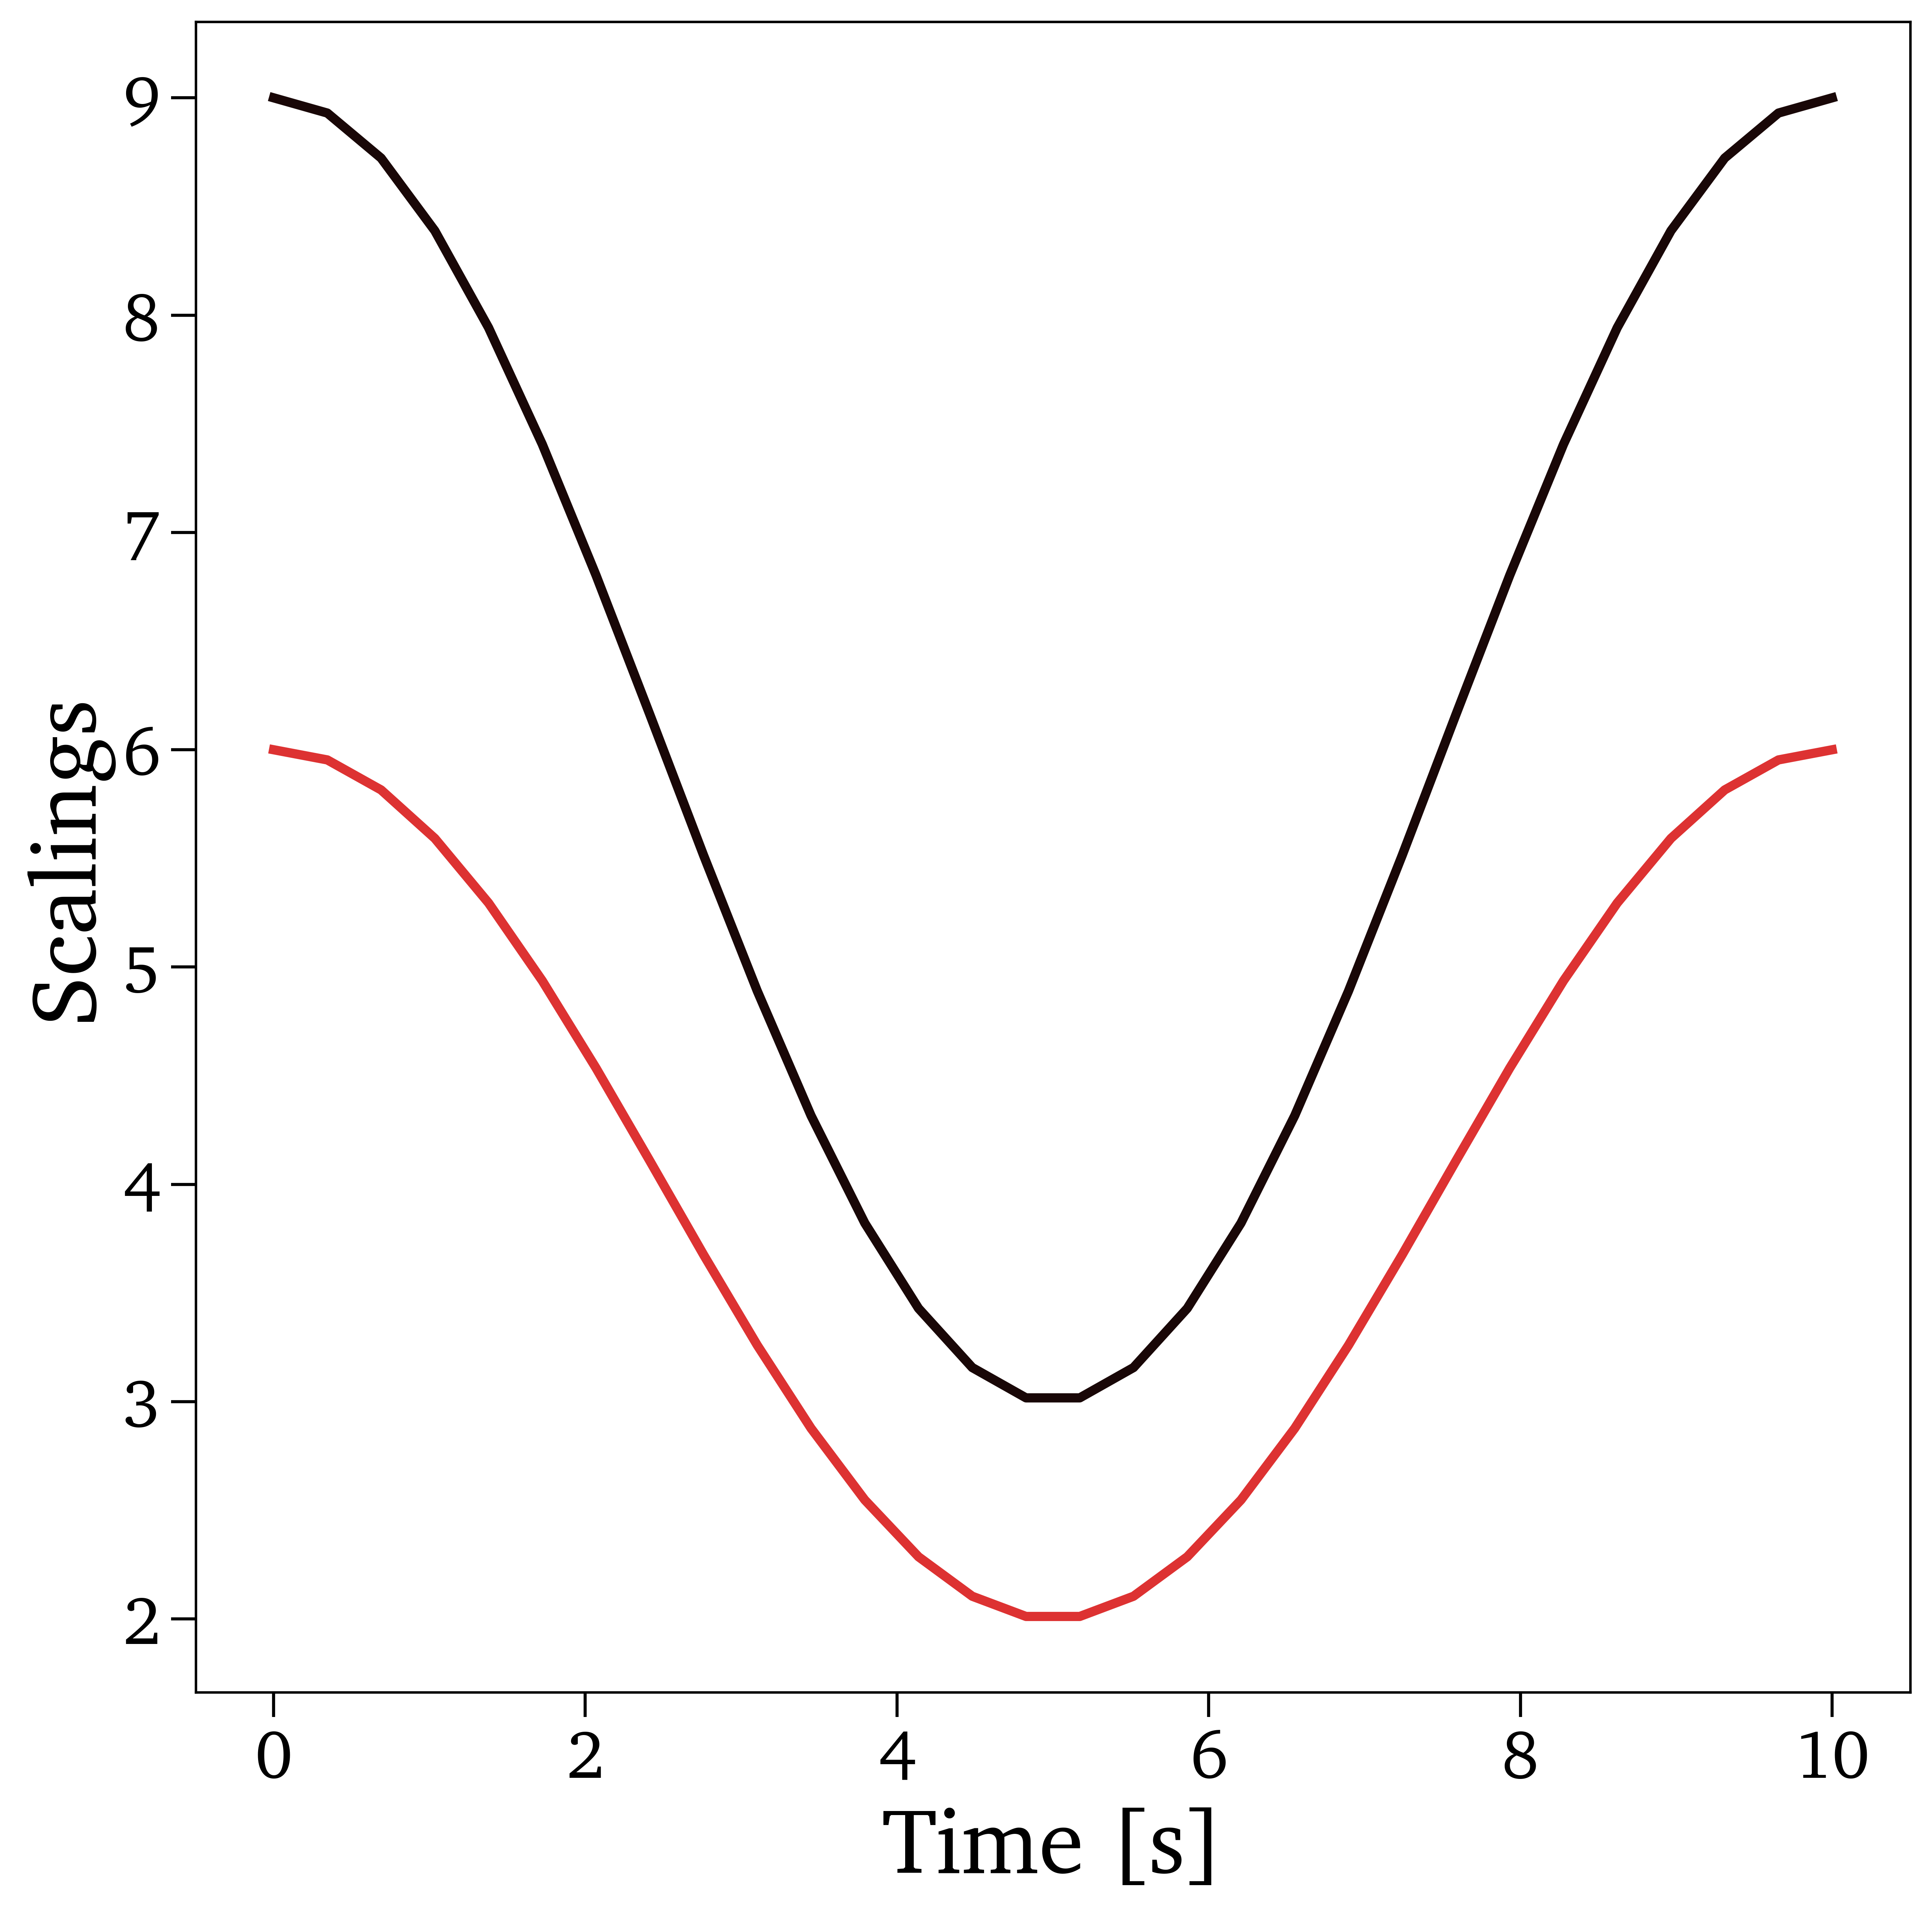

In [5]:
lx0   = 3.
ly0   = 2.

tEnd    = 10.
tVec    = np.linspace(0.,tEnd,30)
lx    = (np.cos(tVec/tEnd*360. / 180.*np.pi)+2)*lx0
ly    = (np.cos(tVec/tEnd*360. / 180.*np.pi)+2)*ly0
    
plt.plot(tVec,lx)
plt.plot(tVec,ly)
plt.xlabel('Time [s]')
plt.ylabel('Scalings')

In [6]:
v_zz  = 0.2
zz0   = 1.

tVec    = np.linspace(0.,10.,30)
for it, t in enumerate(tVec):
    zz  = zz0 + t*v_zz

In [7]:
xMin    = -10.
xMax    = 10.
yMin    = -10.
yMax    = 10.

t0      = 0.
tEnd    = 10.

if (PlotFlg):
    tVec = np.linspace(0,10,10)
else:
    tVec = np.linspace(t0,tEnd,Nt)
XX       = np.zeros((Nx*Ny,Nt))
jt       = 0
for it, t in enumerate(tVec):
    if (t < 4.5 or t > 5.5):
        print('it=', it, '; t=',t)

        if (RotFlg == True):
            Theta = Theta0 + w_Theta*t
            Theta = Theta0 + np.cos(t*4./10.*(np.pi)+2.)*np.pi
        else:
            Theta = Theta0

        if (TransFlg == True):
            Psi   = t*w_Psi
            cr    = ca * Psi
            cx    = cx0 + cr * np.cos(Psi)
            cy    = cy0 + cr * np.sin(Psi)  
        else:
            cx    = 0.
            cy    = 0.

        if (ScaleFlg == True):
            lx    = (np.cos(t/tEnd*360. / 180.*np.pi)+2.)*lx0
            ly    = (np.cos(t/tEnd*360. / 180.*np.pi)+2.)*ly0
        else:
            lx    = lx0*2 
            ly    = ly0*2 

        zz    = zz0 + t*v_zz


        II_  = np.zeros((Nx*Ny,2))
        TT_  = np.zeros((Nx*Ny,1))
        OO_  = np.zeros((Nx*Ny,1))
        Mat  = np.zeros((Nx,Ny))

        if (not RandFlg):
            x    = np.linspace(xMin,xMax,Nx)
            y    = np.linspace(yMin,yMax,Ny)

            i    = 0
            for ix, x_ in enumerate(x):
                for iy, y_ in enumerate(y):
                    xrot_      = x_*np.cos(Theta) + y_*np.sin(Theta)
                    yrot_      = x_*np.sin(Theta) - y_*np.cos(Theta)
                    zx         = np.tanh((xrot_-cx+lx/2)*10.) - np.tanh((xrot_-cx-lx/2)*10.)
                    zy         = np.tanh((yrot_-cy+ly/2)*10.) - np.tanh((yrot_-cy-ly/2)*10.)  
                    II_[i,0]   = x_
                    II_[i,1]   = y_
                    TT_[i,0]   = t
                    OO_[i,0]   = np.exp(zx+zy)*zz
                    Mat[ix,iy] = np.exp(zx+zy)*zz
                    XX[i,it]   = np.exp(zx+zy)*zz

                    i+=1

        else:
            xy      = np.random.rand(Nx*Ny,2)
            xy[:,0] = xy[:,0]*(xMax-xMin) + xMin
            xy[:,1] = xy[:,1]*(yMax-yMin) + yMin

            for i in range(Nx*Ny):
                x_         = xy[i,0]
                y_         = xy[i,1]
                xrot_      = x_*np.cos(Theta) + y_*np.sin(Theta)
                yrot_      = x_*np.sin(Theta) - y_*np.cos(Theta)
                zx         = np.tanh((xrot_-cx+lx/2)*10.) - np.tanh((xrot_-cx-lx/2)*10.)
                zy         = np.tanh((yrot_-cy+ly/2)*10.) - np.tanh((yrot_-cy-ly/2)*10.)  
                II_[i,0]   = x_
                II_[i,1]   = y_
                TT_[i,0]   = t
                OO_[i,0]   = np.exp(zx+zy)*zz
                XX[i,it]   = np.exp(zx+zy)*zz

        if (it==0):
            II = II_
            OO = OO_
            TT = TT_
        else:
            II = np.concatenate([II,II_], axis=0)
            TT = np.concatenate([TT,TT_], axis=0)
            OO = np.concatenate([OO,OO_], axis=0)

        if (PlotFlg):
            plt.figure()
            plt.imshow((Mat).reshape(Nx,Ny), animated=True, origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
            plt.xlabel('x')
            plt.ylabel('y')
            plt.savefig(OutputDir+'/XOrig_it'+str(it)+'.pdf', format='pdf', bbox_inches='tight')
            
        jt += 1

it= 0 ; t= 0.0
it= 1 ; t= 0.02004008016032064
it= 2 ; t= 0.04008016032064128
it= 3 ; t= 0.06012024048096192
it= 4 ; t= 0.08016032064128256
it= 5 ; t= 0.1002004008016032
it= 6 ; t= 0.12024048096192384
it= 7 ; t= 0.1402805611222445
it= 8 ; t= 0.16032064128256512
it= 9 ; t= 0.18036072144288576
it= 10 ; t= 0.2004008016032064
it= 11 ; t= 0.22044088176352705
it= 12 ; t= 0.24048096192384769
it= 13 ; t= 0.2605210420841683
it= 14 ; t= 0.280561122244489
it= 15 ; t= 0.3006012024048096
it= 16 ; t= 0.32064128256513025
it= 17 ; t= 0.3406813627254509
it= 18 ; t= 0.3607214428857715
it= 19 ; t= 0.3807615230460922
it= 20 ; t= 0.4008016032064128
it= 21 ; t= 0.42084168336673344
it= 22 ; t= 0.4408817635270541
it= 23 ; t= 0.4609218436873747
it= 24 ; t= 0.48096192384769537
it= 25 ; t= 0.501002004008016
it= 26 ; t= 0.5210420841683366
it= 27 ; t= 0.5410821643286573
it= 28 ; t= 0.561122244488978
it= 29 ; t= 0.5811623246492986
it= 30 ; t= 0.6012024048096192
it= 31 ; t= 0.6212424849699398
it= 32 ; t= 0.6412825651

it= 314 ; t= 6.292585170340681
it= 315 ; t= 6.312625250501002
it= 316 ; t= 6.332665330661323
it= 317 ; t= 6.352705410821643
it= 318 ; t= 6.372745490981964
it= 319 ; t= 6.3927855711422845
it= 320 ; t= 6.4128256513026045
it= 321 ; t= 6.432865731462925
it= 322 ; t= 6.452905811623246
it= 323 ; t= 6.472945891783567
it= 324 ; t= 6.492985971943887
it= 325 ; t= 6.513026052104208
it= 326 ; t= 6.533066132264529
it= 327 ; t= 6.55310621242485
it= 328 ; t= 6.57314629258517
it= 329 ; t= 6.593186372745491
it= 330 ; t= 6.613226452905812
it= 331 ; t= 6.633266533066132
it= 332 ; t= 6.6533066132264524
it= 333 ; t= 6.673346693386773
it= 334 ; t= 6.693386773547094
it= 335 ; t= 6.713426853707414
it= 336 ; t= 6.733466933867735
it= 337 ; t= 6.753507014028056
it= 338 ; t= 6.773547094188377
it= 339 ; t= 6.793587174348697
it= 340 ; t= 6.813627254509018
it= 341 ; t= 6.833667334669339
it= 342 ; t= 6.853707414829659
it= 343 ; t= 6.8737474949899795
it= 344 ; t= 6.8937875751503
it= 345 ; t= 6.913827655310621
it= 346 

In [8]:
tTry = [0.,2.,4.,6.,8.,10.]

In [9]:
thr1       = 0.95
thr2       = 0.99
thr3       = 0.9999

if (n_modes_vec):
    
    
    pca        = PCAA(XX, scaling='range', n_components=XX.shape[1], nocenter=False)
    C          = pca.X_center
    D          = pca.X_scale
    L          = pca.L
    LL         = np.maximum(L,0.)
    
    plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
    
    vec        = np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL))
    plt.plot(np.arange(len(vec))+1, vec,'-o')


    kk1        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr1)+1
    plt.plot(kk1, vec[kk1-1], 'o', c=ColorVec[1])
    plt.hlines(vec[kk1-1], xmin=0, xmax=kk1, color=ColorVec[1])
    plt.vlines(kk1, ymin=0.1, ymax=vec[kk1-1], color=ColorVec[1])
    
    kk2        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr2)+1
    plt.plot(kk2, vec[kk2-1], 'o', c=ColorVec[2])
    plt.hlines(vec[kk2-1], xmin=0, xmax=kk2, color=ColorVec[2])
    plt.vlines(kk2, ymin=0.1, ymax=vec[kk2-1], color=ColorVec[2])
    
    kk3        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr3)+1
    
    plt.xlim([1, kk2+10])
    plt.ylim([0.1, 1.02])
    plt.xlabel(r'k')
    plt.ylabel('Cumulative Energy')
    #plt.xticks([1,5,10,15,20])
    #plt.yscale('log')
    plt.savefig(OutputDir+'/Rect_CumEnergy.eps', format='eps', bbox_inches='tight')
    
    
    
    jt = 0
    for t in tTry:
        it=0
        while tVec[it]<t:
            it+=1
            
        plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/heavy.mplstyle'))
        plt.figure()
        plt.imshow((XX[:,it-1]).reshape(Nx,Ny), origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.savefig(OutputDir+'/XOrig_t'+str(tVec[it])+'.pdf', format='pdf', bbox_inches='tight')
            
        XX_Vec = []
        for n_modes in n_modes_vec:
            A        = pca.A[:,0:n_modes].T
            AT       = A.T

            XX_pca   = ((XX - C)/D).dot(AT)
            XX_      = (XX_pca.dot(A))*D + C
            

            plt.figure()
            plt.imshow((XX_[:,it-1]).reshape(Nx,Ny), origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
            plt.xlabel('x')
            plt.ylabel('y')
            plt.savefig(OutputDir+'/XRec_t'+str(tVec[it])+'_'+str(n_modes)+'PC.pdf', format='pdf', bbox_inches='tight')
            
            
            XX_Vec.append(XX_)

    
    
        plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
        plt.figure()
        y    = np.linspace(yMin,yMax,Ny)
        plt.plot(y, (XX[:,it-1]).reshape(Nx,Ny)[int(Nx/2),:],  '-', color=ColorVec[0], label='Data')
        for i_mode, n_modes in enumerate(n_modes_vec):
            plt.plot(y, (XX_Vec[i_mode][:,it-1]).reshape(Nx,Ny)[int(Nx/2),:], ':', color=ColorVec[i_mode+1], label=r'$N_{\eta}$='+str(n_modes))
        plt.xlabel('y')
        plt.ylabel('z')
        plt.legend()
        plt.savefig(OutputDir+'/XSlice_t'+str(tVec[it])+'.eps', format='eps', bbox_inches='tight')

        
        jt += 1

In [10]:
# plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/video.mplstyle'))


# img    = [] # some array of images
# frames = [] # for storing the generated images
# fig    = plt.figure(figsize=(10,8))
# for it in range(XX.shape[1]):
#     im     = plt.imshow((XX[:,it]).reshape(Nx,Ny), animated=True, origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
#     plt.xlabel('x')
#     plt.ylabel('y')
#     frames.append([im])
    
# ani = animation.ArtistAnimation(fig, frames, interval=5000, blit=True, repeat_delay=50000)
# writergif = animation.PillowWriter(fps=30)
# ani.save(OutputDir+'/Video.gif',writer=writergif)

In [11]:
if (SaveFlg):

    
    from sklearn.model_selection import train_test_split

    try:
        os.makedirs(OutputDir+'/valid/')
    except:
        pass


    data_id    = 'pts'

    DataInput  = pd.DataFrame(np.concatenate((TT,II), axis=1), columns=['t','x','y'])
    DataOutput = pd.DataFrame(np.concatenate((TT,OO), axis=1), columns=['t','z'])

    n_points   = len(DataInput)

    idx                  = np.arange(n_points)
    train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

    n_valid              = len(valid_idx)
    n_train              = len(train_idx)

    try:
        os.makedirs(OutputDir+'/train/'+data_id+'/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/valid/'+data_id+'/')
    except:
        pass

    DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
    DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

    DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
    DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)